In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib setup to avoid issues with cv2's BGR format
%matplotlib inline

Original Shape (Height, Width, Channels): (148, 270, 3)


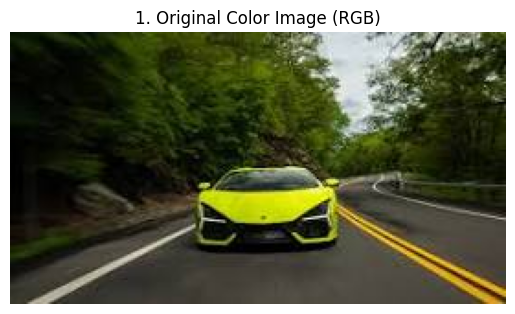

In [ ]:
try:
    img = cv2.imread('/content/drive/MyDrive/PhD/TAShip/Lab_Tutorials/CV/car1.jpg')
    # OpenCV loads images in BGR format by default. We convert it to RGB for Matplotlib.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print(f"Original Shape (Height, Width, Channels): {img.shape}")

    # Displaying the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title("1. Original Color Image (RGB)")
    plt.axis('off') # Hide the axis ticks
    plt.show()
except Exception as e:
    print(f"Error loading image. Make sure 'test_image.jpg' exists in the current folder. Error: {e}")

Grayscale Shape: (148, 270)


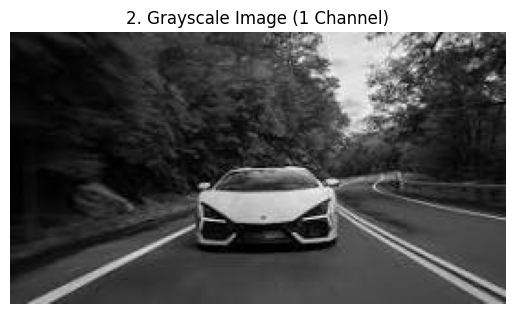

Top-left 5x5 pixel values (0-255):
[[ 9 10 11 13 14]
 [14 14 15 15 15]
 [21 20 20 19 18]
 [24 24 23 23 22]
 [22 23 24 25 26]]


In [ ]:
# Convert to grayscale (1 channel)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(f"Grayscale Shape: {img_gray.shape}")

# Display the grayscale image
plt.imshow(img_gray, cmap='gray')
plt.title("2. Grayscale Image (1 Channel)")
plt.axis('off')
plt.show()

# Example: Pixel values in the top-left corner of the grayscale image
print("Top-left 5x5 pixel values (0-255):")
print(img_gray[:5, :5])


Resized Shape: (200, 300, 3)


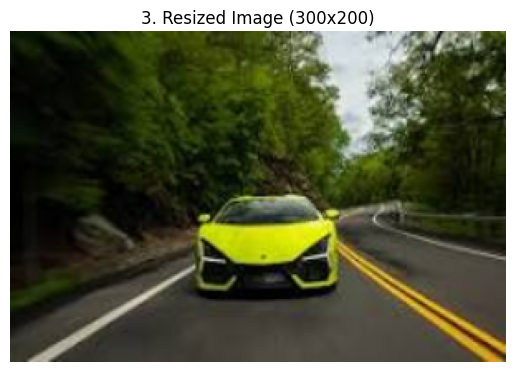

In [ ]:
# Define a target width and height
new_width = 300
new_height = 200

# Use cv2.resize()
resized_img = cv2.resize(img_rgb, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

print(f"Resized Shape: {resized_img.shape}")

plt.imshow(resized_img)
plt.title("3. Resized Image (300x200)")
plt.axis('off')
plt.show()


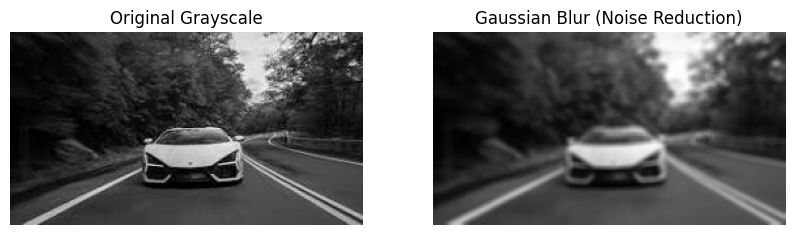

In [ ]:
#######  Smoothing (Blurring) to Remove Noise ###########


# Apply Gaussian Blur (a very common smoothing technique)
# The second argument (5, 5) is the kernel size. Larger kernel = more blur.
# NOTE: The kernel size MUST be an odd number! (e.g., 3, 5, 7, 9, etc.)
# The third argument (0) is std in horizontal direction.
#         (0 tells OpenCV to calculate sigma based on the kernel size -- σ=0.3(2(ksize−1)​−1)+0.8)
img_blurred = cv2.GaussianBlur(img_gray, (5, 5), 3.5)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original Grayscale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_blurred, cmap='gray')
plt.title("Gaussian Blur (Noise Reduction)")
plt.axis('off')

plt.show()

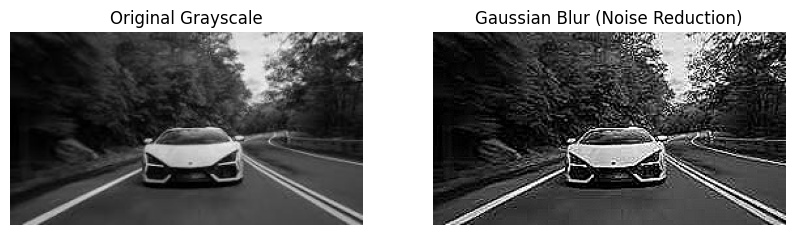

In [ ]:
###### Sharpening the features #######

# Enhances details. Sum=1 to preserve brightness.
filter_sharpen = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

img_sharpened = cv2.filter2D(img_gray, -1, filter_sharpen)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original Grayscale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_sharpened, cmap='gray')
plt.title("Gaussian Blur (Noise Reduction)")
plt.axis('off')

plt.show()

#Affine Transforms and Convolution Filters


In [ ]:

def display_images(images, titles):
    """Utility function to display multiple images."""
    fig, axes = plt.subplots(1, len(images), figsize=(18, 6))
    if len(images) == 1:
        axes = [axes] # Ensure axes is iterable even for one image

    for ax, image, title in zip(axes, images, titles):
        # Determine cmap based on image shape (grayscale vs color)
        cmap = 'gray' if len(image.shape) == 2 or image.shape[2] == 1 else None

        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

Loaded image size: 270x148
Scaled image size: 135x74
Rotation angle: [[  0.70710678   0.70710678 -12.78531727]
 [ -0.70710678   0.70710678 117.13351365]]


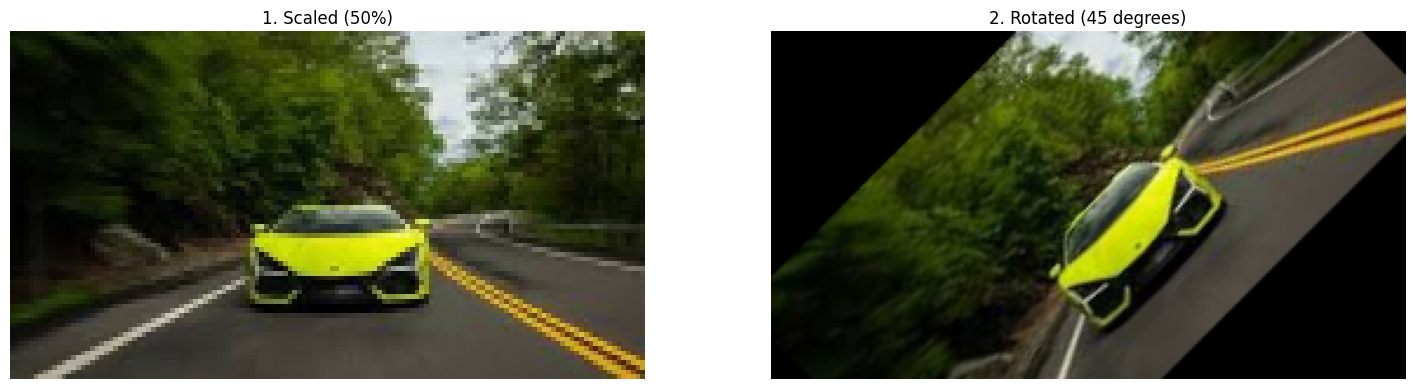

In [ ]:
H, W, _ = img_rgb.shape
print(f"Loaded image size: {W}x{H}")

# --- 1. Scaling Example ---
# Shrink the image by half in both dimensions
scale_factor = 0.5
scaled_img = cv2.resize(img_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
print(f"Scaled image size: {scaled_img.shape[1]}x{scaled_img.shape[0]}")


# --- 2. Rotation Example ---
angle = 45 # Rotate by 45 degrees
center = (W // 2, H // 2) # Rotate around the center of the image
scale = 1.0 # Keep the original scale

# Get the 2x3 Affine Rotation Matrix (M_rot)
M_rot = cv2.getRotationMatrix2D(center, angle, scale)
print(f"Rotation angle: {M_rot}")

# Apply the Affine Warp to the color image
rotated_img = cv2.warpAffine(img_rgb, M_rot, (W, H))


# --- 3. Visualization ---
display_images(
    [scaled_img, rotated_img],
    ["1. Scaled (50%)", "2. Rotated (45 degrees)"]
)

# Custom Convolutional Filtering (The CNN Connection)

A filter (or kernel) is a small, typically square matrix that is swept across the image (convolved) to change the value of each pixel based on its neighbors. This is the core operation of a CNN!

By manually defining the kernel, we apply a specific effect. When a CNN is trained, it learns the optimal values for these kernel matrices automatically.

<Figure size 1800x900 with 0 Axes>

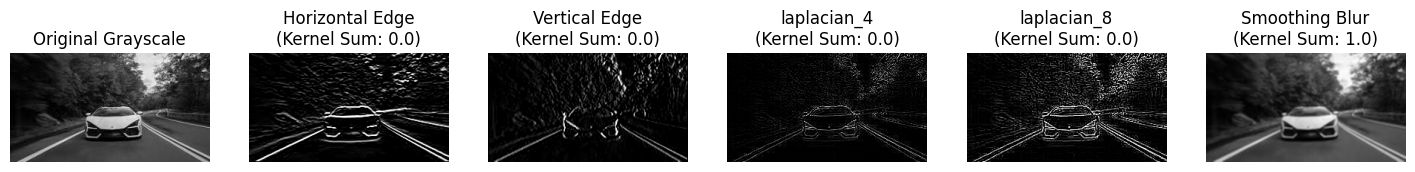

In [ ]:
# --- 1. Define the Filter Bank (Collection of Kernels) ---
filters = {}

# A. Horizontal Edge Kernel (Prewitt): Detects horizontal intensity changes. Sum=0.
filters['Horizontal Edge'] = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
], dtype=np.float32)

# B. Vertical Edge Kernel: Detects vertical intensity changes. Sum=0.
filters['Vertical Edge'] = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=np.float32)


# C. Laplacian Kernel: Detects intensity changes by computing the second spatial derivative. Sum =0
#    ∇2f(x,y)=f(x+1,y)+f(x−1,y)+f(x,y+1)+f(x,y−1)−4f(x,y)
filters["laplacian_4"] = np.array([
    [ 0,  1, 0],
    [ 1, -4, 1],
    [ 0,  1, 0]], dtype=float)

# D. Laplacian Kernel: Detects intensity changes by computing the second spatial derivative. Sum =0
#    ∇2f(x,y)=f(x+1,y)+f(x−1,y)+f(x,y+1)+f(x,y−1)−4f(x,y)
#                     +f(x+1,y+1)+f(x+1,y-1)+f(x-1,y+1)+f(x-1,y-1)
filters["laplacian_8"] = np.array([
    [ 1,  1, 1],
    [ 1, -8, 1],
    [ 1,  1, 1]], dtype=float)

# E. Smoothing (Averaging Blur) Kernel: Reduces noise. Sum=1 (1/9 * 9 = 1).
filters['Smoothing Blur'] = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
], dtype=np.float32) / 9.0


# --- 2. Apply Filtering and Collect Feature Maps ---
feature_maps = []
titles = []

for title, kernel in filters.items():
    # Apply the kernel to the grayscale image
    img_filtered = cv2.filter2D(img_gray, -1, kernel)
    feature_maps.append(img_filtered)
    titles.append(title + "\n(Kernel Sum: " + str(np.round(kernel.sum(), 2)) + ")")


# --- 3. Visualization ---
# Display all feature maps side-by-side
plt.figure(figsize=(18, 9))
display_images(
    [img_gray] + feature_maps,
    ["Original Grayscale"] + titles
)

# Blob Detection Pipeline (Filter $\rightarrow$ Threshold $\rightarrow$ Contour)

This cell demonstrates the full pipeline to convert extracted features into a single, clean binary mask:

1. Filtering: Extracts the features (edges).

2. Thresholding: Creates a sparse binary image (the dots).

3. Morphological Operations (Dilation/Closing): Fills in the gaps and connects nearby features (the "closer ones").

4. Contour Filtering: Finds the largest object (the main blob).

5. Mask Generation: Draws the largest object as a solid white mask.

Found 7 initial contours. Largest blob area: 4203


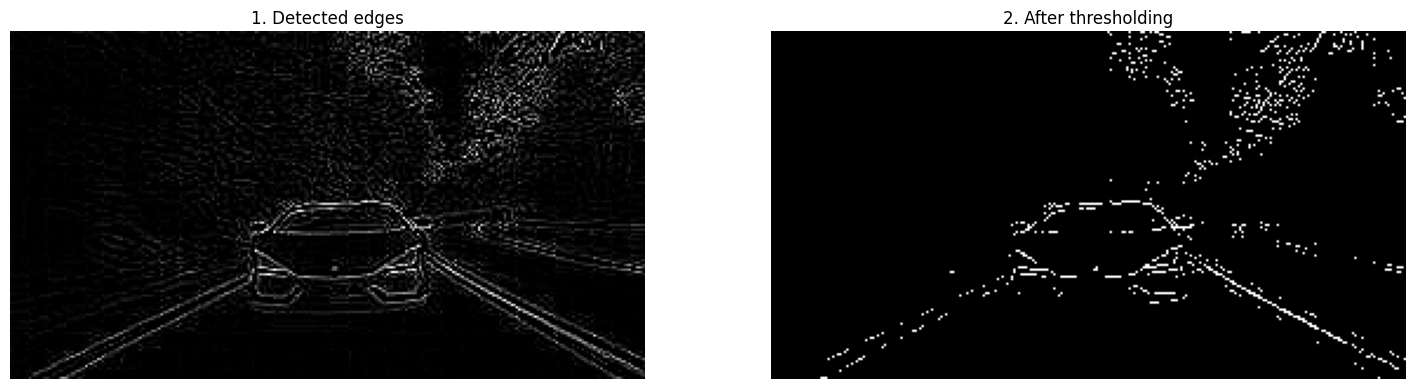

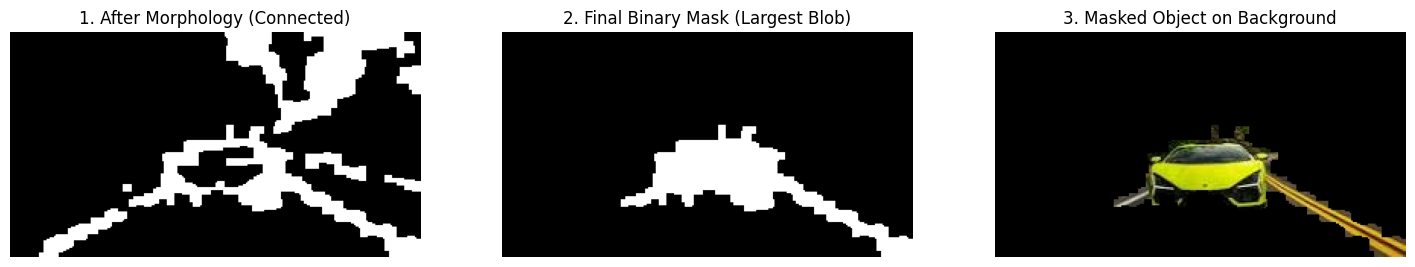

In [ ]:
# We'll use the 4-neighbourhood Laplacian kernel again (try others also)
edge_kernel = np.array([
    [ 0,  1, 0],
    [ 1, -4, 1],
    [ 0,  1, 0]], dtype=float)

# 1. Filtering & Absolute Scaling (Feature Map Creation)
img_filtered_edges = cv2.filter2D(img_gray, -1, edge_kernel)
img_abs_edges = cv2.convertScaleAbs(img_filtered_edges)


# 2. Thresholding (Initial Binary Dots)
threshold_value = 100
_, img_thresholded = cv2.threshold(img_abs_edges, threshold_value, 255, cv2.THRESH_BINARY)


# 3. Morphological Operations (Connecting the dots and filling holes)
# Define a kernel for operations (larger kernel = more aggressive filling)
kernel = np.ones((5, 5), np.uint8)
# Dilation: Makes white regions larger, helping connect adjacent dots
img_dilated = cv2.dilate(img_thresholded, kernel, iterations=1)
# Closing: Dilation followed by Erosion. Excellent for closing small holes/gaps
img_morphed = cv2.morphologyEx(img_dilated, cv2.MORPH_CLOSE, kernel, iterations=1)


# 4. Contour Detection and Filtering (Identifying the Largest Blob)
# Find all boundaries (contours) in the cleaned binary image
contours, _ = cv2.findContours(img_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

final_mask = np.zeros_like(img_gray)
masked_object = np.zeros_like(img_rgb)

if contours:
    # Find the contour with the maximum area (assuming the bird/stump is the largest feature)
    largest_contour = max(contours, key=cv2.contourArea)

    # 5. Mask Generation (Draw the largest contour as a solid, filled shape)
    # Draw the largest contour onto the blank mask image (255=white, -1=filled)
    cv2.drawContours(final_mask, [largest_contour], -1, 255, -1)

    # Apply the mask to the original color image
    masked_object[final_mask == 255] = img_rgb[final_mask == 255]

    print(f"Found {len(contours)} initial contours. Largest blob area: {cv2.contourArea(largest_contour):.0f}")

else:
    print("No significant blobs found after thresholding and morphology.")


display_images(
    [img_abs_edges, img_thresholded],
    ["1. Detected edges", "2. After thresholding"]
)


display_images(
    [img_morphed, final_mask, masked_object],
    ["1. After Morphology (Connected)", "2. Final Binary Mask (Largest Blob)", "3. Masked Object on Background"]
)
